# Models


# Model 4

- get_dummies categorical data(`EDUCATION`,`MARRIAGE`,`SEX`,'PAY_1', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6').
- exclude features `BILL_ATM2`, ..., `BILL_ATM6`.

## Import libraries/packages 

In [1]:
### General libraries ###
import pandas as pd
from pandas.api.types import CategoricalDtype
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import seaborn as sns
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import graphviz 
from graphviz import Source
from IPython.display import SVG
import os

##################################

### ML Models ###
from sklearn.linear_model import LogisticRegression
from sklearn import tree
# from sklearn.tree.export import export_text
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split, cross_val_score,cross_validate
from sklearn.preprocessing import StandardScaler,LabelEncoder

##################################

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.decomposition import PCA

### Metrics ###
from yellowbrick.classifier import ConfusionMatrix
from sklearn import metrics
from sklearn.metrics import f1_score,confusion_matrix, mean_squared_error, mean_absolute_error, classification_report, roc_auc_score, roc_curve, precision_score, recall_score

## Part 1: Load and clean the data

In this section we will load the data from the csv file and check for any "impurities", such as null values or duplicate rows. If any of these will appear, we will remove them from the data set. We will also plot the correlations of the class column with all the other columns.

In [2]:
# Load the data.
data = pd.read_csv('default of credit card clients.csv')

# Information
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 25 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   ID         30000 non-null  int64
 1   LIMIT_BAL  30000 non-null  int64
 2   SEX        30000 non-null  int64
 3   EDUCATION  30000 non-null  int64
 4   MARRIAGE   30000 non-null  int64
 5   AGE        30000 non-null  int64
 6   PAY_1      30000 non-null  int64
 7   PAY_2      30000 non-null  int64
 8   PAY_3      30000 non-null  int64
 9   PAY_4      30000 non-null  int64
 10  PAY_5      30000 non-null  int64
 11  PAY_6      30000 non-null  int64
 12  BILL_AMT1  30000 non-null  int64
 13  BILL_AMT2  30000 non-null  int64
 14  BILL_AMT3  30000 non-null  int64
 15  BILL_AMT4  30000 non-null  int64
 16  BILL_AMT5  30000 non-null  int64
 17  BILL_AMT6  30000 non-null  int64
 18  PAY_AMT1   30000 non-null  int64
 19  PAY_AMT2   30000 non-null  int64
 20  PAY_AMT3   30000 non-null  int64
 21  PAY_AMT4   3

Text(0.5, 1.0, 'Value distribution for "dpnm"')

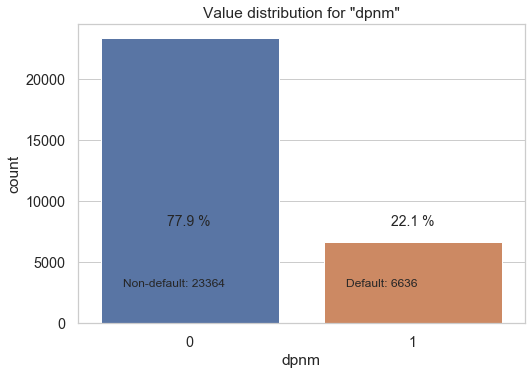

In [3]:
# The frequency of defaults
yes = data.dpnm.sum()
no = len(data)-yes

# Percentage
yes_perc = round(yes/len(data)*100, 1)
no_perc = round(no/len(data)*100, 1)

sns.set(context='notebook', style='whitegrid',
            font='sans-serif', font_scale=1.3)
sns.countplot(data['dpnm'])
plt.annotate('Non-default: {}'.format(no), xy=(-0.3, 15000), xytext=(-0.3, 3000), size=12)
plt.annotate('Default: {}'.format(yes), xy=(0.7, 15000), xytext=(0.7, 3000), size=12)
plt.annotate(str(no_perc)+" %", xy=(-0.3, 15000), xytext=(-0.1, 8000), size=14)
plt.annotate(str(yes_perc)+" %", xy=(0.7, 15000), xytext=(0.9, 8000), size=14)
plt.title('Value distribution for "dpnm"')

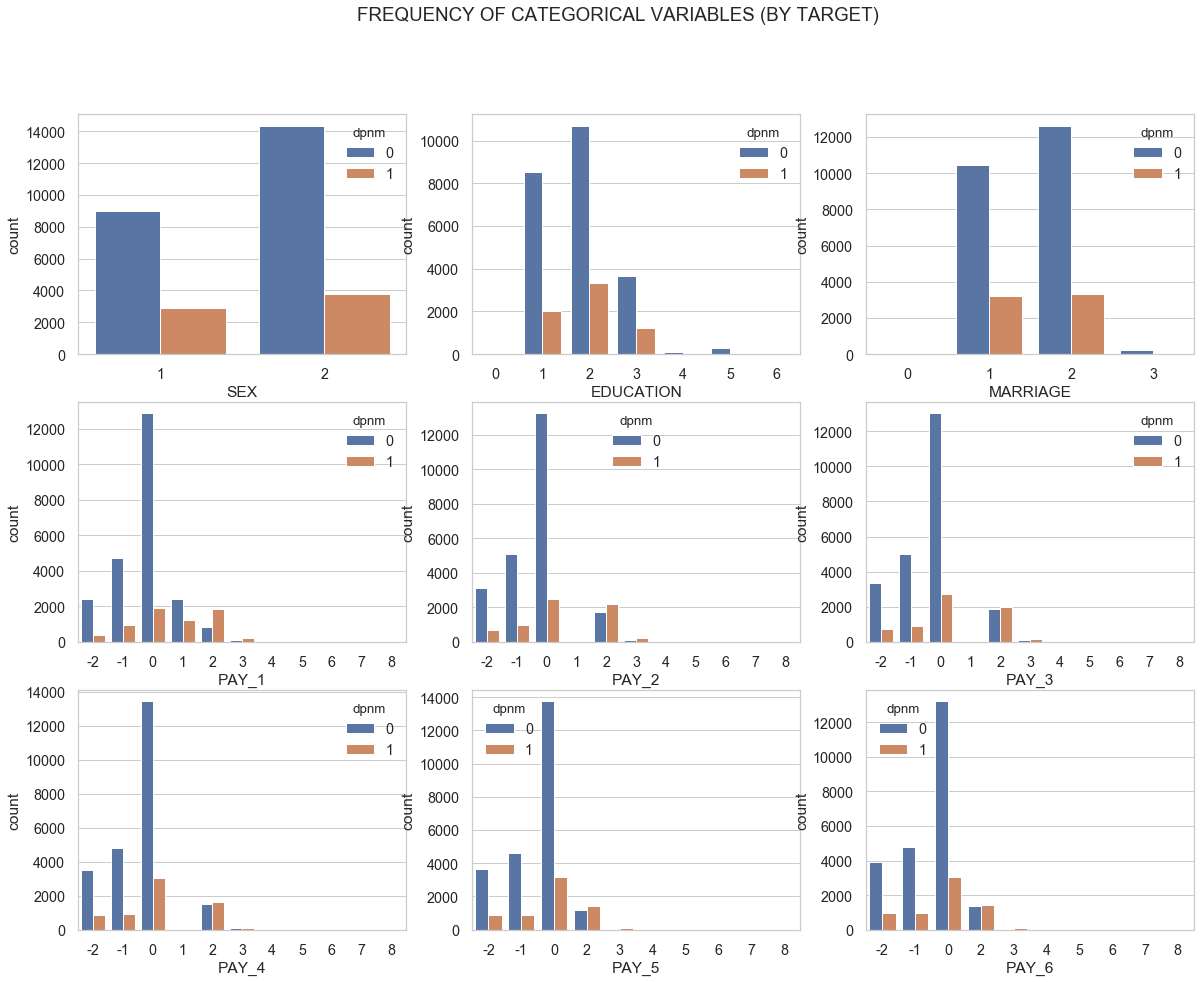

In [4]:
# Creating a new dataframe with categorical variables
subset = data[['SEX', 'EDUCATION', 'MARRIAGE', 'PAY_1', 'PAY_2', 'PAY_3', 'PAY_4',
               'PAY_5', 'PAY_6', 'dpnm']]

f, axes = plt.subplots(3, 3, figsize=(20, 15), facecolor='white',constrained_layout=False)
f.suptitle('FREQUENCY OF CATEGORICAL VARIABLES (BY TARGET)')
ax1 = sns.countplot(x="SEX", hue="dpnm", data=data,  ax=axes[0, 0])
ax2 = sns.countplot(x="EDUCATION", hue="dpnm", data=data, ax=axes[0, 1])
ax3 = sns.countplot(x="MARRIAGE", hue="dpnm", data=data, ax=axes[0, 2])
ax4 = sns.countplot(x="PAY_1", hue="dpnm", data=data,  ax=axes[1, 0])
ax5 = sns.countplot(x="PAY_2", hue="dpnm", data=data,  ax=axes[1, 1])
ax6 = sns.countplot(x="PAY_3", hue="dpnm", data=data,  ax=axes[1, 2])
ax7 = sns.countplot(x="PAY_4", hue="dpnm", data=data,  ax=axes[2, 0])
ax8 = sns.countplot(x="PAY_5", hue="dpnm", data=data,  ax=axes[2, 1])
ax9 = sns.countplot(x="PAY_6", hue="dpnm", data=data,  ax=axes[2, 2])

In [5]:
data.columns


Index(['ID', 'LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_1',
       'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6', 'dpnm'],
      dtype='object')

Since the `ID` column is for indexing purposes only, we remove it from the data set.

In [5]:
# Replace value '0' with value '3'.
data['MARRIAGE'] = data['MARRIAGE'].replace(0, 3)

# Replace values '0','5' and '6' with value '4'.
data['EDUCATION'] = data['EDUCATION'].replace([0, 5, 6], 4)

In [6]:
# Drop "ID" column.
data = data.drop(['ID'], axis=1)

Now we check for duplicate rows. If any, we remove them from the data set, since they provide only reduntant information.

In [7]:
# Check for duplicate rows.
print(f"There are {data.duplicated().sum()} duplicate rows in the data set.")

# Remove duplicate rows.
data = data.drop_duplicates()
print("The duplicate rows were removed.")

There are 35 duplicate rows in the data set.
The duplicate rows were removed.


We also check for null values.

In [8]:
# Check for null values.
print(
    f"There are {data.isna().any().sum()} cells with null values in the data set.")

There are 0 cells with null values in the data set.


Below is the plot of the correlation matrix for the data set.

## Part 2: Pre-processing

In this part we prepare our data for our models. This means that we choose the columns that will be our independed variables and which column the class that we want to predict. Once we are done with that, we split our data into train and test sets and perfom a standardization upon them.

In [9]:
# OneHot encoder for columns 'EDUCATION','MARRIAGE','SEX','PAY_1', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6' .
data = pd.get_dummies(
    data, columns=['EDUCATION','MARRIAGE','SEX','PAY_1', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6'])

In [10]:
# Select feature and class column.
X = data.drop(columns=['dpnm', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6'])
y = data['dpnm']

In [11]:
len(X.columns)

82

## Feature selection

In [12]:
# Best k for CV accuracy:17

In [13]:
from sklearn.feature_selection import SelectKBest

In [16]:
def find_best_k(X, y, tol=0.001, n_iter_no_change=10, n_clusters=2, verbose=False):
    from sklearn.feature_selection import SelectKBest
    scores = []
    n_features = len(X.columns)
    no_improvement_counter = 0
    best_validation_score_ = -np.inf

 # Main loop
    for kappa in range(1, n_features+1):
        X_new = SelectKBest(k=kappa).fit_transform(X, y)
        sc = StandardScaler()
        sc.fit(X_new)
        X_new = sc.transform(X_new)
        X_new = pd.DataFrame(X_new)
        model = KMeans(n_clusters=2, random_state=25).fit(X_new)
        X_new['cluster'] = model.labels_
        X_train, X_test, y_train, y_test = train_test_split(
            X_new, y, test_size=0.3, random_state=25)
        scaler = StandardScaler()
        scaler.fit(X_train)
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)
    # Initialize a Logistic Regression estimator.
        logreg = LogisticRegression(
            multi_class='auto', random_state=25, n_jobs=-1)
    # Train the estimator.
        logreg.fit(X_train, y_train)
        kappa_score = logreg.score(X_test,y_test)
#         cross_val_score(logreg, X_new, y, cv=10).mean()
        scores.append(kappa_score)
        last_valid_score = scores[-1]

        if verbose:
            print(
                f'K={kappa}, No improvement for {no_improvement_counter} rounds, Best score: {best_validation_score_}')

        if last_valid_score < (best_validation_score_ + tol):
            no_improvement_counter += 1
        else:
            no_improvement_counter = 0

        if no_improvement_counter > n_iter_no_change:
            break

        if last_valid_score > best_validation_score_:
            best_validation_score_ = last_valid_score

    fig, ax = plt.subplots()
    ax.plot([k for k in range(1,len(scores)+1)],
            scores, marker='o', label="Scores")
    ax.axvline(x=scores.index(best_validation_score_)+1, ymin=0, ymax=1, color='r', ls='--',
               label=f'Best score\nfor K={scores.index(best_validation_score_)+1}')
    plt.legend()
    plt.title(
        f'Scores for classification with K-means')

K=1, No improvement for 0 rounds, Best score: -inf
K=2, No improvement for 0 rounds, Best score: 0.8083426028921024
K=3, No improvement for 1 rounds, Best score: 0.8083426028921024
K=4, No improvement for 2 rounds, Best score: 0.8083426028921024
K=5, No improvement for 0 rounds, Best score: 0.8100111234705228
K=6, No improvement for 1 rounds, Best score: 0.8100111234705228
K=7, No improvement for 2 rounds, Best score: 0.8100111234705228
K=8, No improvement for 0 rounds, Best score: 0.8110122358175751
K=9, No improvement for 0 rounds, Best score: 0.8121245828698554
K=10, No improvement for 1 rounds, Best score: 0.8121245828698554
K=11, No improvement for 0 rounds, Best score: 0.8137931034482758
K=12, No improvement for 1 rounds, Best score: 0.8137931034482758
K=13, No improvement for 2 rounds, Best score: 0.8137931034482758
K=14, No improvement for 3 rounds, Best score: 0.8137931034482758
K=15, No improvement for 4 rounds, Best score: 0.8143492769744161
K=16, No improvement for 5 rounds

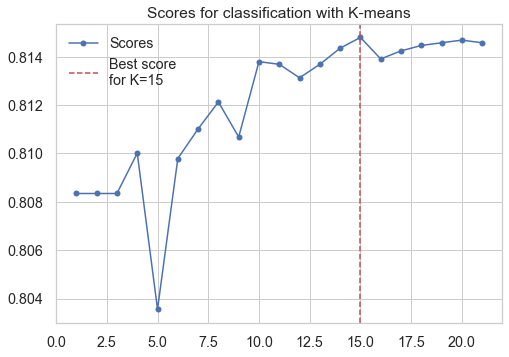

In [17]:
find_best_k(X, y,verbose=True)

In [18]:
X = SelectKBest(k=15).fit_transform(X, y)

## Perform K-means clustering analysis

In [19]:
# Standardization
sc = StandardScaler()
sc.fit(X)
X = sc.transform(X)
X = pd.DataFrame(X)

In [20]:
model = KMeans(n_clusters=2, random_state=25).fit(X)

In [21]:
X['cluster'] = model.labels_

In [22]:
# Split to train and test sets.
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=25)

In [23]:
# Standardization
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## Part 3: Modeling

In this section we build and try 3 models:
 - Logistic Regression
 - Decision tree
 - Neural network



In [24]:
scoring=['accuracy','f1','precision','recall','roc_auc']

## Logistic Regression

In [25]:
# Initialize a Logistic Regression estimator.
logreg = LogisticRegression(multi_class='auto', random_state=25, solver='sag',n_jobs=-1)

# Train the estimator.
logreg.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=-1, penalty='l2', random_state=25,
                   solver='sag', tol=0.0001, verbose=0, warm_start=False)

In [26]:
# Make predictions.
log_pred = logreg.predict(X_test)

# CV accuracy
# cv_logreg = cross_val_score(logreg, X, y, cv=10).mean()
cv_logreg = cross_validate(logreg, X, y, scoring=scoring, cv=10)

In [27]:
cv_logreg.keys()

dict_keys(['fit_time', 'score_time', 'test_accuracy', 'test_f1', 'test_precision', 'test_recall', 'test_roc_auc'])

## Metrics

In [28]:
# cv_logreg = cross_validate(logreg, X, y, scoring=scoring, cv=10)

# Accuracy: 1 is perfect prediction.
print('Accuracy: %.3f' % logreg.score(X_test, y_test))

# Cross-Validation accuracy
print('Cross-validation accuracy: %0.3f' % cv_logreg['test_accuracy'].mean())

# Precision
print('cv Precision: %.3f' % cv_logreg['test_precision'].mean())

# Recall
print('cv Recall: %.3f' % cv_logreg['test_recall'].mean())

# f1 score: best value at 1 (perfect precision and recall) and worst at 0.
print('cv F1 score: %.3f' % cv_logreg['test_f1'].mean())

print('cv auc: %.3f' % cv_logreg['test_roc_auc'].mean())

Accuracy: 0.815
Cross-validation accuracy: 0.818
cv Precision: 0.674
cv Recall: 0.345
cv F1 score: 0.456
cv auc: 0.757


In [30]:
# Accuracy: 1 is perfect prediction.
print('Accuracy: %.3f' % logreg.score(X_test, y_test))

# Cross-Validation accuracy
# print('Cross-validation accuracy: %0.3f' % cv_logreg)

# Precision
print('Precision: %.3f' % precision_score(y_test, log_pred))

# Recall
print('Recall: %.3f' % recall_score(y_test, log_pred))

# f1 score: best value at 1 (perfect precision and recall) and worst at 0.
print('F1 score: %.3f' % f1_score(y_test, log_pred))

Accuracy: 0.815
Precision: 0.672
Recall: 0.341
F1 score: 0.452


In [31]:
# Predict probabilities for the test data.
logreg_probs = logreg.predict_proba(X_test)

# Keep Probabilities of the positive class only.
logreg_probs = logreg_probs[:, 1]

# Compute the AUC Score.
auc_logreg = roc_auc_score(y_test, logreg_probs)
print('AUC: %.2f' % auc_logreg)

AUC: 0.76


## Confusion matrix for Logistic Regression

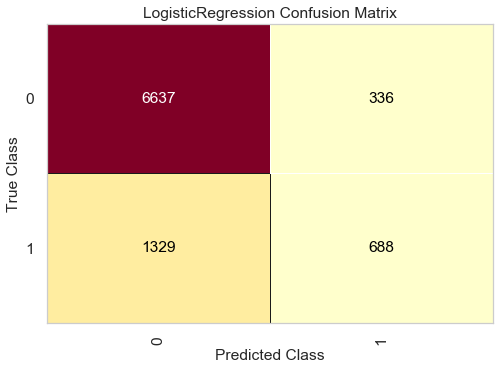

In [32]:
cm = ConfusionMatrix(logreg, is_fitted=True)
cm.score(X_test, y_test)
cm.poof()

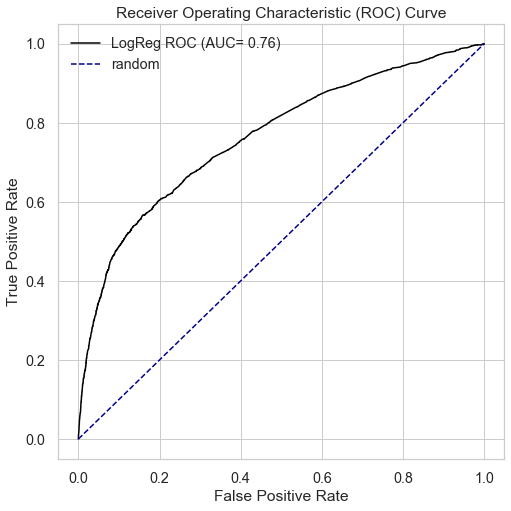

In [33]:
# Get the ROC curves.
logreg_fpr, logreg_tpr, logreg_thresholds = roc_curve(y_test, logreg_probs)

# Plot the ROC curves.
plt.figure(figsize=(8, 8))
plt.plot(logreg_fpr, logreg_tpr, color='black',
         label='LogReg ROC (AUC= %0.2f)' % auc_logreg)
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--', label='random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

## Decision tree

In [38]:
# Initialize a decision tree estimator.
tr = tree.DecisionTreeClassifier(
    max_depth=5, criterion='gini', random_state=25)

# Train the estimator.
tr.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=5, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=25, splitter='best')

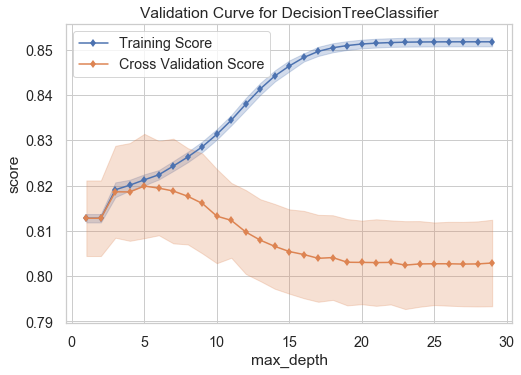

In [39]:
from yellowbrick.model_selection import ValidationCurve



viz = ValidationCurve(
    tr, param_name="max_depth",
    param_range=np.arange(1, 30), cv=10, scoring="accuracy"
)

# Fit and show the visualizer
viz.fit(X, y)
viz.show()

Text(0.5, 1.0, 'Decision Tree')

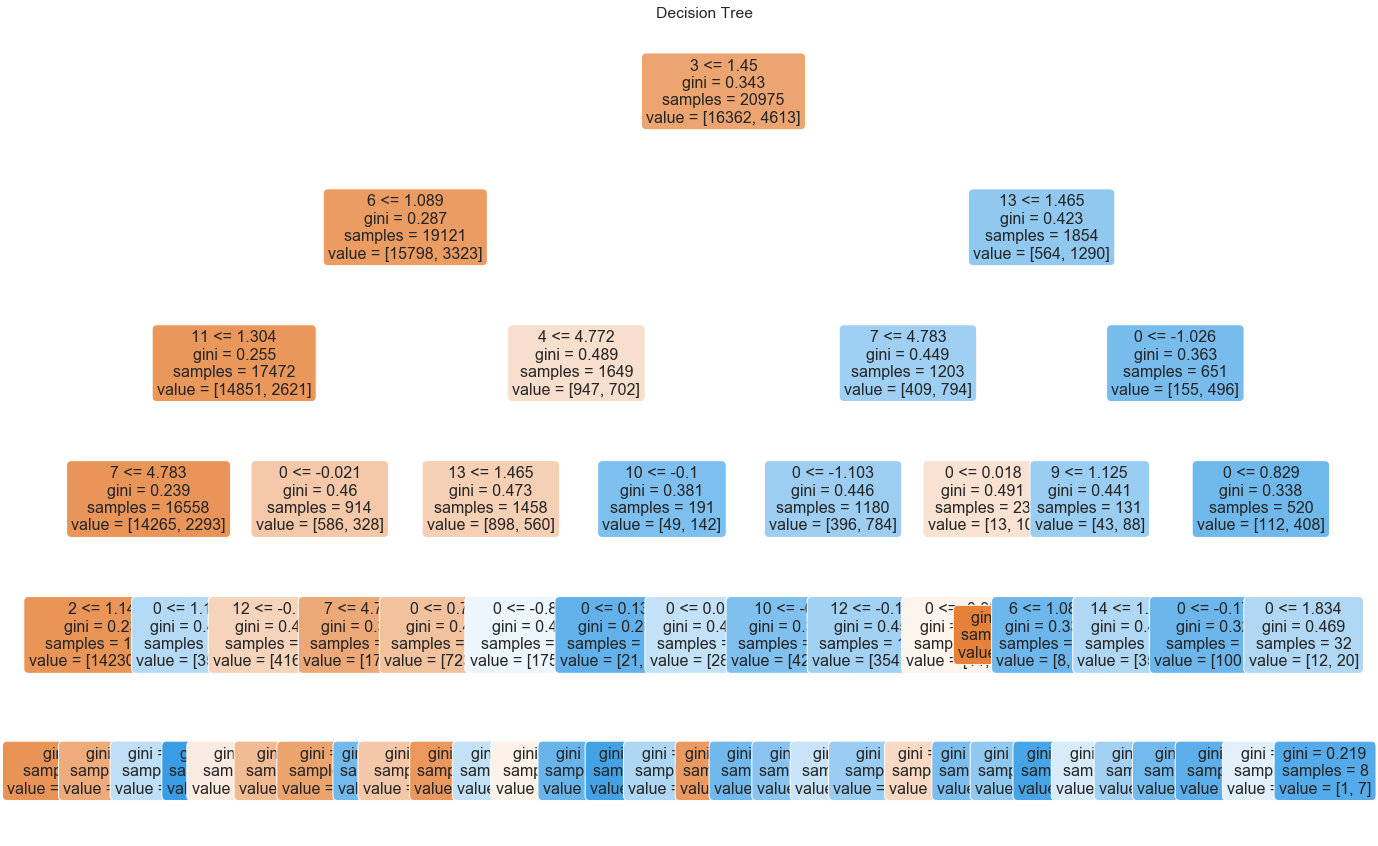

In [40]:
# Plot the tree.
fig = plt.figure(figsize=(23, 15))
tree.plot_tree(tr.fit(X_train, y_train), feature_names=X.columns,
               filled=True, rounded=True, fontsize=16)
plt.title('Decision Tree')

In [208]:
# Print the tree in a simplified version.
r = export_text(tr, feature_names=X.columns.tolist())
print(r)

NameError: name 'export_text' is not defined

In [41]:
# Make predictions.
tr_pred = tr.predict(X_test)

# CV accuracy.
cv_tr = cross_val_score(tr, X, y, cv=10).mean()

## Metrics

In [42]:
cv_tr = cross_validate(tr, X, y, scoring=scoring, cv=10)

# Accuracy: 1 is perfect prediction.
print('Accuracy: %.3f' % tr.score(X_test, y_test))

# Cross-Validation accuracy
print('Cross-validation accuracy: %0.3f' % cv_tr['test_accuracy'].mean())

# Precision
print('cv Precision: %.3f' % cv_tr['test_precision'].mean())

# Recall
print('cv Recall: %.3f' % cv_tr['test_recall'].mean())

# f1 score: best value at 1 (perfect precision and recall) and worst at 0.
print('cv F1 score: %.3f' % cv_tr['test_f1'].mean())

print('cv auc: %.3f' % cv_tr['test_roc_auc'].mean())

Accuracy: 0.815
Cross-validation accuracy: 0.820
cv Precision: 0.679
cv Recall: 0.354
cv F1 score: 0.464
cv auc: 0.723


In [43]:
# Accuracy: 1 is perfect prediction.
print('Accuracy: %.3f' % tr.score(X_test, y_test))

# Cross-Validation accuracy
# print('Cross-validation accuracy: %0.3f' % cv_tr)

# Precision
print('Precision: %.3f' % precision_score(y_test, tr_pred))

# Recall
print('Precision: %.3f' % recall_score(y_test, tr_pred))

# f1 score: best value at 1 (perfect precision and recall) and worst at 0.
print('F1 score: %.3f' % f1_score(y_test, tr_pred))

Accuracy: 0.815
Precision: 0.674
Precision: 0.340
F1 score: 0.452


In [45]:
# Predict propabilities for the test data.
tr_probs = tr.predict_proba(X_test)

# Keep Probabilities of the positive class only.
tr_probs = tr_probs[:, 1]

# Compute the AUC Score.
auc_tr = roc_auc_score(y_test, tr_probs)
print('AUC: %.2f' % auc_tr)

AUC: 0.72


## Confusion Matrix for Decision tree

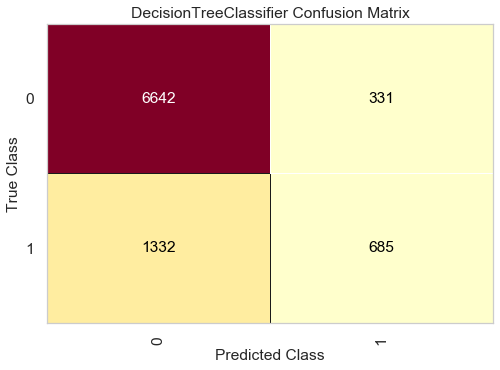

In [46]:
cm = ConfusionMatrix(tr, is_fitted=True)
cm.score(X_test, y_test)
cm.poof()

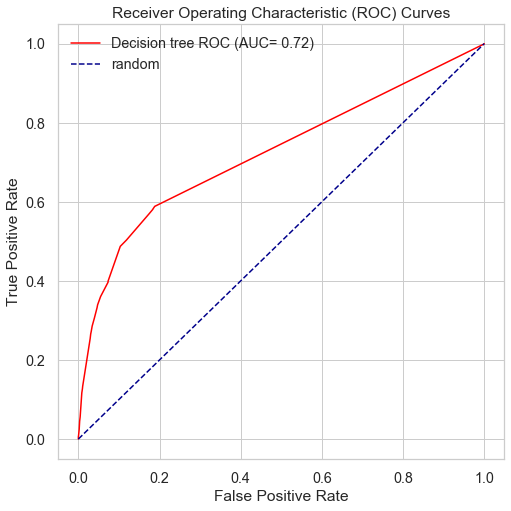

In [47]:
# Get the ROC Curves.
tr_fpr, tr_tpr, tr_thresholds = roc_curve(y_test, tr_probs)

# Plot the ROC curves.
plt.figure(figsize=(8, 8))
plt.plot(tr_fpr, tr_tpr, color='red',
         label='Decision tree ROC (AUC= %0.2f)' % auc_tr)
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--', label='random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.legend()
plt.show()

## Neural network

In [48]:
# Initialize a Multi-layer Perceptron classifier.
mlp = MLPClassifier(hidden_layer_sizes=(12, 5), max_iter=1000,
                    random_state=25, shuffle=True, verbose=False)

# Train the classifier.
mlp.fit(X_train, y_train)

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(12, 5), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=1000,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=25, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)

In [49]:
# Make predictions.
mlp_pred = mlp.predict(X_test)

# CV accuracy
cv_mlp = cross_val_score(mlp, X, y, cv=10).mean()

## Metrics

In [50]:
cv_mlp = cross_validate(mlp, X, y, scoring=scoring, cv=10)

# Accuracy: 1 is perfect prediction.
# print('Accuracy: %.3f' % mlp.score(X_test, y_test))

# Cross-Validation accuracy
print('Cross-validation accuracy: %0.3f' % cv_mlp['test_accuracy'].mean())

# Precision
print('cv Precision: %.3f' % cv_mlp['test_precision'].mean())

# Recall
print('cv Recall: %.3f' % cv_mlp['test_recall'].mean())

# f1 score: best value at 1 (perfect precision and recall) and worst at 0.
print('cv F1 score: %.3f' % cv_mlp['test_f1'].mean())

print('cv auc: %.3f' % cv_mlp['test_roc_auc'].mean())

Cross-validation accuracy: 0.819
cv Precision: 0.674
cv Recall: 0.355
cv F1 score: 0.464
cv auc: 0.763


In [51]:
# Accuracy: 1 is perfect prediction.
print('Accuracy: %.3f' % mlp.score(X_test, y_test))

# Cross-Validation accuracy
# print('Cross-validation accuracy: %0.3f' % cv_mlp)

# Precision
print('Precision: %.3f' % precision_score(y_test, mlp_pred))

# Recall
print('Recall: %.3f' % recall_score(y_test, mlp_pred))

# f1 score: best value at 1 (perfect precision and recall) and worst at 0.
print('F1 score: %.3f' % f1_score(y_test, mlp_pred))

Accuracy: 0.817
Precision: 0.668
Recall: 0.371
F1 score: 0.477


In [53]:
# Predict probabilities for the test data.
mlp_probs = mlp.predict_proba(X_test)

# Keep probabilities of the positive class only.
mlp_probs = mlp_probs[:, 1]

# Compute the AUC Score.
auc_mlp = roc_auc_score(y_test, mlp_probs)
print('AUC: %.2f' % auc_mlp)

AUC: 0.76


## Confusion Matrix for Multi-layer Perceptron

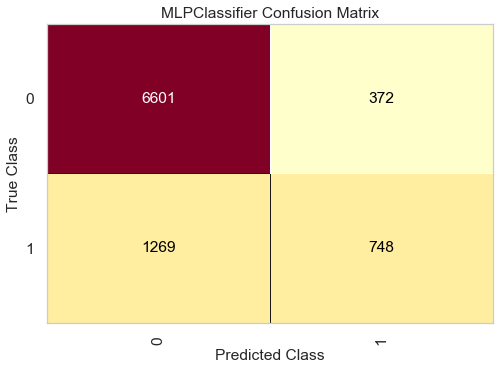

In [54]:
cm = ConfusionMatrix(mlp, is_fitted=True)
cm.score(X_test, y_test)
cm.poof()

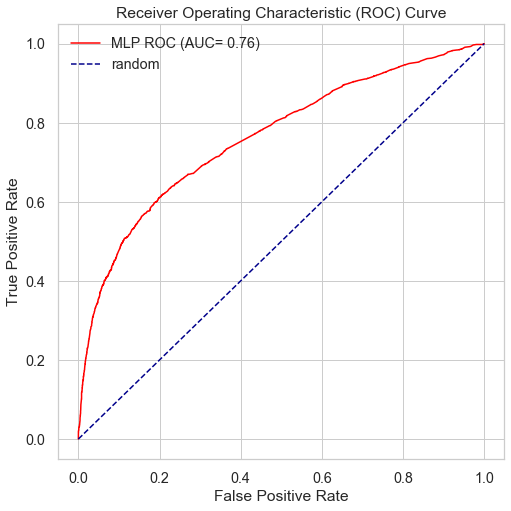

In [55]:
# Get the ROC curves.
mlp_fpr, mlp_tpr, mlp_thresholds = roc_curve(y_test, mlp_probs)

# Plot the ROC curve.
plt.figure(figsize=(8, 8))
plt.plot(mlp_fpr, mlp_tpr, color='red', label='MLP ROC (AUC= %0.2f)' % auc_mlp)
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--', label='random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

## Results

In [ ]:
metrics = ['Accuracy', 'CV accuracy', 'Precision', 'Recall', 'F1', 'ROC AUC']

# Plot metrics.
fig = go.Figure(data=[
    go.Bar(name='Logistic Regression', x=metrics,
           y=[logreg.score(X_test, y_test), cv_logreg, precision_score(y_test, log_pred), recall_score(y_test, log_pred), f1_score(y_test, log_pred), auc_logreg]),
    go.Bar(name='Decision tree', x=metrics,
           y=[tr.score(X_test, y_test), cv_tr, precision_score(y_test, tr_pred), recall_score(y_test, tr_pred), f1_score(y_test, tr_pred), auc_tr]),
    go.Bar(name='Neural Network', x=metrics,
           y=[mlp.score(X_test, y_test), cv_mlp, precision_score(y_test, mlp_pred), recall_score(y_test, mlp_pred), f1_score(y_test, mlp_pred), auc_mlp]),
])

fig.update_layout(title_text='Metrics for each model',
                  barmode='group', xaxis_tickangle=-45, bargroupgap=0.05)
fig.show()

In [ ]:
# Plot the ROC curve.
plt.figure(figsize=(8, 8))
plt.plot(mlp_fpr, mlp_tpr, color='blue',
         label='MLP ROC (AUC= %0.3f)' % auc_mlp)
plt.plot(tr_fpr, tr_tpr, color='green',
         label='Decision tree ROC (AUC= %0.3f)' % auc_tr)
plt.plot(logreg_fpr, logreg_tpr, color='red',
         label='LogReg ROC (AUC= %0.3f)' % auc_logreg)
plt.plot([0, 1], [0, 1], color='black', linestyle='--', label='random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.legend()
plt.show()

In [ ]:
d = {
    'Models': ['Logistic Regression', 'Decision Tree', 'Neural Network (MLP)'],
    'Accuracy': [logreg.score(X_test, y_test), tr.score(X_test, y_test), mlp.score(X_test, y_test)],
    'CV Accuracy': [cv_logreg, cv_tr, cv_mlp],
    'Precision': [precision_score(y_test, log_pred), precision_score(y_test, tr_pred), precision_score(y_test, mlp_pred)],
    'Recall': [recall_score(y_test, log_pred), recall_score(y_test, tr_pred), recall_score(y_test, mlp_pred)],
    'F1': [f1_score(y_test, log_pred), f1_score(y_test, tr_pred), f1_score(y_test, mlp_pred)],
    'AUC': [auc_logreg, auc_tr, auc_mlp]
}

results = pd.DataFrame(data=d).round(3).set_index('Models')
results

## Paper results


### 1) The comparisons of data mining techniques for the predictive accuracy of probability of default of credit card clients. Expert Systems with Applications 36 (2009) 2473–2480

|                     | Error rate | Accuracy |
|---------------------|:----------:|:--------:|
| Logistic Regression |    0.18    |   0.82   |
| Decision tree       |    0.17    |   0.83   |
| Neural Network      |    0.17    |   0.83   |

### 2) Liu,  R.L.  (2018) Machine  Learning  Approaches  to  Predict Default  of  Credit  Card  Clients. Modern Economy, 9, 1828-1838. 

|                | Accuracy |   F1   |
|----------------|:--------:|:------:|
|  Decision tree |  0.7973  | 0.4912 |
| Neural Network |  0.8227  | 0.4593 |

## Evaluating Performance

### Hypothesis Testing
- $H_{0}$: There is no significant difference in the test set error rate of two supervised learner models $M_{1}$ and $M_{2}$ built with the same training data.
- $H_{1}$: There is significant difference in the test set error rate of two supervised learner models $M_{1}$ and $M_{2}$ built with the same training data.

### Comparing models with a single test set

**Step 1.** (Initialization). Given:
- Two models, $M_{1}$ and $M_{2}$ built with the same training data.
- One test set $A$ with $card(A)=n$.
- Error rate $E_{1}$ for model $M_{1}$ on test set $A$.
- Error rate $E_{2}$ for model $M_{2}$ on test set $A$.

**Step 2.** Compute:  

$$P=\frac{|E_{1}-E_{2}|}{\sqrt{\frac{(v_{1}+v_{2})}{n}}}$$

**Step 3.** Conclude:  
If $P≥2$, hypothesis $H_{1}$ holds. Otherwise, $H_{0}$ is true.


In [56]:
from itertools import combinations

# Dictionary with all the classifiers.
models = {'LogisticRegression': logreg,
          'DecisionTreeClassifier': tr,
          'MLPClassifier': mlp
          }


def evaluating_performance(models=None):
    if models == None:
        return 'No models to compare'
    else:
        for model in combinations(models.keys(), 2):
            confusion1 = confusion_matrix(
                y_test, models[model[0]].predict(X_test))
            TP1 = confusion1[1, 1]
            TN1 = confusion1[0, 0]
            FP1 = confusion1[0, 1]
            FN1 = confusion1[1, 0]
#             E1 = (FP1+FN1)/len(X_test)
            confusion2 = confusion_matrix(
                y_test, models[model[1]].predict(X_test))
            TP2 = confusion2[1, 1]
            TN2 = confusion2[0, 0]
            FP2 = confusion2[0, 1]
            FN2 = confusion2[1, 0]
#             E2 = (FP2+FN2)/len(X_test)
            E1 = models[model[0]].score(X_test, y_test)
            E2 = models[model[1]].score(X_test, y_test)
            var1 = E1*(1-E1)
            var2 = E2*(1-E2)
            n = len(X_test)
            P = abs(E1-E2)/np.sqrt((var1+var2)/n)
            print(
                f'Comparing Performance between {model[0]} and {model[1]}:', P.round(3))
            if P < 2:
                print(
                    f'There is no significant diferrence between {model[0]} and {model[1]}\n')
            else:
                print(
                    f'==>The models {model[0]} and {model[1]} are significant different<==\n')


evaluating_performance(models)

Comparing Performance between LogisticRegression and DecisionTreeClassifier: 0.038
There is no significant diferrence between LogisticRegression and DecisionTreeClassifier

Comparing Performance between LogisticRegression and MLPClassifier: 0.462
There is no significant diferrence between LogisticRegression and MLPClassifier

Comparing Performance between DecisionTreeClassifier and MLPClassifier: 0.424
There is no significant diferrence between DecisionTreeClassifier and MLPClassifier



***